<a href="https://colab.research.google.com/github/sweta98/Bug-severity-classification/blob/main/DS_Bug_Severity_Classifier_Unsplit_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATTENTION: First manually upload the data file in the root directory of the session storage

In [ ]:
!nvidia-smi

Sun Apr 30 21:10:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |    747MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q transformers datasets

# Load data



In [ ]:

# Using one-hot embedding here
def category_to_one_hot(category, categories):
  """
  Return one-hot vector of label
  """
  one_hot = np.zeros(len(categories))
  index = categories.index(category)
  one_hot[index] = 1
  return one_hot


In [ ]:
from datasets import Dataset

import csv
import numpy as np

from tqdm import tqdm

f = open("merged_methods_buggy.csv")
reader = csv.reader(f)
rows = [row for row in reader]
fields = rows[0]
severity_idx = fields.index('Severity')
code_idx = fields.index('SourceCode')


labels = ['Critical', 'High', 'Medium', 'Low']

dataset_text = [row[code_idx] for row in tqdm(rows[1:])]
dataset_label = [category_to_one_hot(row[severity_idx], labels) for row in tqdm(rows[1:])]
dataset = Dataset.from_dict({
    'text': dataset_text,
    'label': dataset_label
})

100%|██████████| 3358/3358 [00:00<00:00, 150457.46it/s]


# Data preprocessing

Specify which model below:

`'codebert', 'graphcodebert'`

In [ ]:
model_name = 'graphcodebert'

model_full_name = f"microsoft/{model_name}-base"

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoModel, AutoTokenizer
import torch
import torch.nn as nn

In [ ]:
from datasets import DatasetDict
from imblearn.over_sampling import SMOTE
import pandas as pd

# tokenize
tokenizer = AutoTokenizer.from_pretrained(model_full_name)
def tokenize(data):
    return tokenizer(data['text'], padding='max_length',
              truncation=True, max_length=512,
              return_tensors="pt"  # return pytorch tensors
              )

dataset = dataset.map(tokenize, batched=True)

seed = 0


# split data (paper -> train 70%, valid 15%, test 15%)
train_test_valid = dataset.train_test_split(test_size=0.3, seed=seed)
test_valid = train_test_valid['test'].train_test_split(test_size=0.5, seed=seed)

split_dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'val': test_valid['train']})

Map:   0%|          | 0/3358 [00:00<?, ? examples/s]

In [ ]:
print(len(split_dataset['train']), len(split_dataset['test']), len(split_dataset['val']))

2350 504 504


# Model

The RoBERTa classification head is a fully connected layer that takes the final hidden state of the RoBERTa model as input and produces logits as output. The logits are then passed through a softmax function to obtain predicted probabilities for each class.

Huggingface's AutoModelForSequenceClassification for CodeBERT by default uses RoBERTa classifier

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_full_name, num_labels=4)

Some weights of the model checkpoint at microsoft/graphcodebert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.out_proj.weight', 'classifier

# Train

To skip training, upload `best_model` to environment and go to the next section

According to paper:

1. Freeze CodeBERT layers to train classification layer with large amount of epochs (40 epochs). Early stopping technique with patience=3 for each epoch.

2. Unfreeze CodeBERT layers to train entire model with small learning rate and fewer epoch numbers to prevent overfitting (5 epochs as suggested by previous research)

In [ ]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, IntervalStrategy
from transformers.trainer_callback import CallbackHandler
import os

## Training part 1: training the classifier

In [ ]:
# Default training loss is cross entropy loss (just like the paper)

# Freeze the base model, train the classifier head
for param in model.base_model.parameters():
    param.requires_grad = False
model.classifier.requires_grad_()

# define the training arguments
training_args = TrainingArguments(
  num_train_epochs=40,
  warmup_steps=500,
  weight_decay=0.01,
  logging_dir='./logs',
  logging_steps=10,
  output_dir='./results',
  per_device_train_batch_size=16,
  per_device_eval_batch_size=16,
  evaluation_strategy="epoch",
  logging_strategy="epoch",
  save_strategy="epoch",
  load_best_model_at_end=True
)


early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3,
                                                early_stopping_threshold=0.01)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_dataset['train'],
    eval_dataset=split_dataset['val'],
    callbacks=[early_stopping_callback]
)

trainer.train()

# We can ignore warning that 'text' in the dataset is not expected by the model

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.629100,0.494872
2,0.460900,0.421524
3,0.432500,0.406249
4,0.417200,0.392980
5,0.399900,0.382195
6,0.390400,0.373101
7,0.380700,0.368815
8,0.377400,0.365310


TrainOutput(global_step=1176, training_loss=0.43602717003854763, metrics={'train_runtime': 808.4801, 'train_samples_per_second': 116.268, 'train_steps_per_second': 7.273, 'total_flos': 4946576665804800.0, 'train_loss': 0.43602717003854763, 'epoch': 8.0})

## Training part 2: fine-tune

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # sklearn score function can't process one-hot: convert to 0-4 values
    labels = [label.argmax(axis=-1) for label in labels]
    predictions = logits.argmax(axis=-1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": accuracy, "f1": f1}

In [ ]:
# Unfreeze all layers
model.requires_grad_()


training_args = TrainingArguments(
  learning_rate=2e-5,
  num_train_epochs=20,
  weight_decay=0.01,
  output_dir="./results",
  per_device_train_batch_size=16,
  per_device_eval_batch_size=16,
  evaluation_strategy="epoch",
  logging_strategy="epoch",
  save_strategy="epoch",
  load_best_model_at_end=True,
  metric_for_best_model='f1'
)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_dataset['train'],
    eval_dataset=split_dataset['val'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

trainer.train()

# Save the best model
model.save_pretrained("./best_model/")
tokenizer.save_pretrained("./best_model/")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.351700,0.322145,0.732143,0.678183
2,0.277600,0.289446,0.746032,0.721775
3,0.200000,0.290854,0.769841,0.750967
4,0.126000,0.336834,0.740079,0.740216
5,0.086700,0.370308,0.765873,0.761591
6,0.058400,0.420930,0.759921,0.759008
7,0.040800,0.434993,0.769841,0.765544
8,0.034300,0.484832,0.779762,0.770641


('./best_model/tokenizer_config.json',
 './best_model/special_tokens_map.json',
 './best_model/vocab.json',
 './best_model/merges.txt',
 './best_model/added_tokens.json',
 './best_model/tokenizer.json')

For future reuse, save `./best_model` to local

# Load saved model

In [ ]:
# Loading a saved model
model = AutoModelForSequenceClassification.from_pretrained("./best_model")


# Eval

## Eval using test set

In [ ]:
model.eval()
pred_vec = trainer.predict(split_dataset['test']).predictions
predictions = np.argmax(pred_vec, axis=1)

target_vec = np.array(split_dataset['test']['label'])
target = np.argmax(target_vec, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, classification_report

# accuracy
accuracy = accuracy_score(target, predictions)
print('accuracy', accuracy)

# precision
precision = precision_score(target, predictions, average='weighted')
print('precision', precision)

# recall
recall = recall_score(target, predictions, average='weighted')
print('recall', recall)

# F1-weighted
f1_weighted = f1_score(target, predictions, average='weighted')
print('f1_weighted', f1_weighted)

# F1-perclass
f1_perclass = f1_score(target, predictions, average=None)
print('f1_perclass', f1_perclass)

# AUC
auc = roc_auc_score(target_vec, pred_vec, multi_class='ovr', average='micro')
print('auc', auc)

# MCC
mcc = matthews_corrcoef(target, predictions)
print('mcc', mcc)

# classification report
report = classification_report(target, predictions)
print(report)


accuracy 0.7797619047619048
precision 0.7685621842695343
recall 0.7797619047619048
f1_weighted 0.7710442841261472
f1_perclass [0.47761194 0.83870968 0.98989899 0.57591623]
auc 0.9212385571512555
mcc 0.5908292561112268
              precision    recall  f1-score   support

           0       0.59      0.40      0.48        40
           1       0.81      0.88      0.84       312
           2       0.98      1.00      0.99        49
           3       0.62      0.53      0.58       103

    accuracy                           0.78       504
   macro avg       0.75      0.70      0.72       504
weighted avg       0.77      0.78      0.77       504



In [ ]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(target_vec.ravel(), pred_vec.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.92


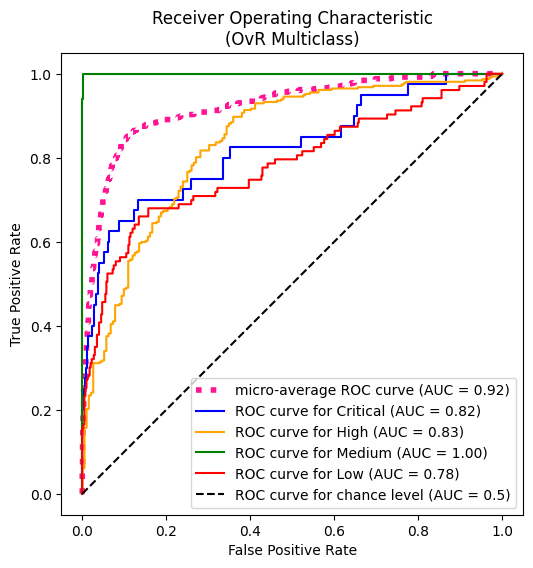

In [ ]:
from itertools import cycle
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
  fpr["micro"],
  tpr["micro"],
  label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
  color="deeppink",
  linestyle=":",
  linewidth=4,
)

colors = cycle(["blue", "orange", "green", "red"])
for class_id, color in zip(range(4), colors):
  RocCurveDisplay.from_predictions(
      target_vec[:, class_id],
      pred_vec[:, class_id],
      name=f"ROC curve for {labels[class_id]}",
      color=color,
      ax=ax,
  )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Receiver Operating Characteristic\n(OvR Multiclass)")
plt.legend()
plt.show()

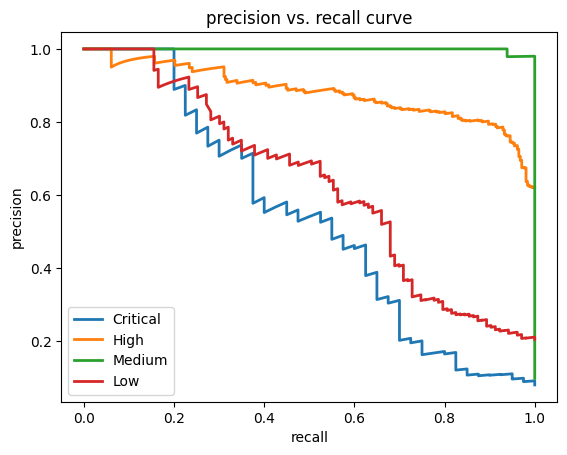

In [ ]:
from sklearn.metrics import precision_recall_curve
precision = dict()
recall = dict()
for i in range(4):
  precision[i], recall[i], _ = precision_recall_curve(target_vec[:, i],
                                                      pred_vec[:, i])
  plt.plot(recall[i], precision[i], lw=2, label=labels[i])

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

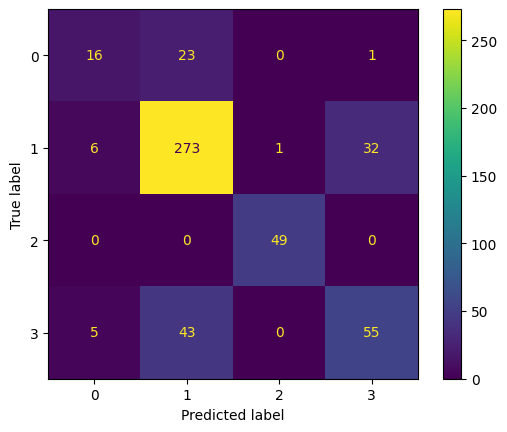

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(target, predictions)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cm_display.plot()
plt.show()

## Run a single test case

In [ ]:

from torch.nn.functional import softmax


def run(text, model, tokenizer):
  tokens = tokenizer(text, padding='max_length',
              truncation=True, max_length=512,
              return_tensors="pt"  # return pytorch tensors
              )

  # load onto gpu
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model = model.to(device)
  tokens = tokens.to(device)

  with torch.no_grad():
    outputs = model(**tokens)
  prob = softmax(outputs.logits, dim=1).tolist()[0]
  pred = torch.argmax(outputs.logits, dim=1).tolist()[0]
  print("=======Raw code========")
  print(repr(text))
  print()
  print("=====Readable code=====")
  print(text)
  print()
  print("Prediction: ", labels[pred])
  print("Confidence: ", {labels[i]: round(prob[i], 3) for i in range(len(prob))})

In [ ]:
test_text = """
public static int getMax(int a, int b) {
  return 0;
}
"""

run(test_text, model, tokenizer)


=======Raw code========
'\npublic static int getMax(int a, int b) { \n  return 0; \n}\n'

=====Readable code=====

public static int getMax(int a, int b) { 
  return 0; 
}


Prediction:  High
Confidence:  {'Critical': 0.0, 'High': 1.0, 'Medium': 0.0, 'Low': 0.0}
